We start by importing the streets data and gdf.

- Segment streets into pieces
- Get grade of each piece
- Draw perpendiculars from each endpoint to find sidewalk (say w/i 1.2 meters)
- Cut sidewalk at those points
-    find segment
-    split in two (look at rounding.ipynb)
-    be sure to add *unique* ids
-    DO NOT REMOVE ANYTHING, just add "grade" column


In [104]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString

In [2]:
# the node names here are irrelevant
brighton_streets = gpd.read_file("../../data/brighton/brighton_streets.shp").to_crs("EPSG:26919")
brighton_sidewalks = gpd.read_file("../../data/brighton/brighton_sidewalks_diditwork.shp")

In [11]:
brighton_sidewalks

,street_id,forward,geometry
0,8647362,0,"LINESTRING (322560.6 4691152.1, 322613.4 46911..."
1,8647362,0,"LINESTRING (322613.4 4691129.8, 322629 4691123.5)"
2,8647663,1,"LINESTRING (322629 4691123.5, 322683.6 4691233.5)"
3,8647663,1,"LINESTRING (322683.6 4691233.5, 322683.6 46912..."
4,8647663,1,"LINESTRING (322683.6 4691233.5, 322714.5 4691294)"
5,8647663,0,"LINESTRING (322716.3 4691293.1, 322685.4 46912..."
6,8647663,0,"LINESTRING (322685.4 4691232.5, 322630.8 46911..."
7,8647362,1,"LINESTRING (322630.8 4691122.8, 322661.7 46911..."
8,8647362,1,"LINESTRING (322661.7 4691108.6, 322682.2 46910..."
9,8647362,1,"LINESTRING (322682.2 4691099.6, 322731 4691078.5)"


In [3]:
def round_pt(pt):
    a, b = pt
    a = round(a,1)
    b = round(b,1)
    return Point(a,b)

def round_edge(edge):
    if type(edge) == MultiLineString:
        edges = edge.geoms
        return MultiLineString(list(map(round_edge, edges)))
    else:
        return LineString(map(round_pt, list(edge.coords)))

brighton_streets.geometry = brighton_streets.geometry.map(round_edge)

In [4]:
brighton_streets.drop(inplace=True, columns=['key','name','highway','sw_left','sw_right'])


In [5]:
from shapely.ops import linemerge

def safe_linemerge(line):
    if type(line) == MultiLineString:
        return linemerge(line.geoms)
    else:
        return line

def safe_pre_explode(line):
    if type(line) == MultiLineString:
        return line.geoms
    else:
        return line
    
def safe_explode(gdf):
    rows = []
    old_rows =[]
    for i, row in gdf.iterrows():
        if type(row['geometry']) == MultiLineString:
            mline = row.geometry
            for line in mline:
                new_row = row
                new_row.geometry = line
                rows.append(new_row)
                old_rows.append(i)
            
    new_gdf = gpd.GeoDataFrame(rows)
    new_gdf.crs = "EPSG:26919"
    gdf = gdf.drop(old_rows)
    gdf = gdf.append(new_gdf)
    return gdf
 

In [6]:
brighton_streets = safe_explode(brighton_streets).reset_index(drop=True)

In [7]:
# Thank you Sean Gilles https://gist.github.com/sgillies/465156#file_cut.py
from shapely.geometry import LineString, Point
from copy import deepcopy
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
        

# here's me
def recursive_cut(line, distance):
    if [line] == cut(line, distance):
        return [line]
    else:
        segment, rest = cut(line, distance)
        return [segment] + recursive_cut(rest, distance)
    
           
def list_explode(gdf):
    rows = []
    old_rows = []
    for i, row in gdf.iterrows():
        mline = row['cut_geometry']
        new_rows = [deepcopy(row) for i in range(len(row['cut_geometry']))]
        for n, inline in enumerate(mline):
            new_rows[n]['geometry'] = inline
            old_rows.append(i)
        rows.extend(new_rows)
    new_gdf = gpd.GeoDataFrame(rows).reset_index(drop=True)
    new_gdf.crs = "EPSG:26919"
    return new_gdf


In [8]:
CUT_LENGTH = 4
brighton_streets['cut_geometry'] = brighton_streets.geometry.map(lambda x : recursive_cut(x,4))
# brighton_streets.cut_geometry.map(len).sum() == 41900
# len(list_explode(brighton_streets))



In [9]:
brighton_streets = list_explode(brighton_streets).drop(columns=['cut_geometry','u','v','length'])

In [10]:
brighton_streets.geometry = brighton_streets.geometry.map(round_edge)

In [12]:
brighton_streets = brighton_streets.to_crs("EPSG:4326")

In [13]:
brighton_streets

,id,geometry
0,8647362,LINESTRING (-71.15442971235149 42.352395880060...
1,8647362,LINESTRING (-71.15438432689349 42.352382324350...
2,8647362,LINESTRING (-71.15433897220183 42.352369668595...
3,8647362,LINESTRING (-71.15429358678098 42.352356112848...
4,8647362,LINESTRING (-71.15424944546179 42.352343434251...
5,8647362,LINESTRING (-71.15420406007782 42.352329878467...
6,8647362,LINESTRING (-71.1541587054576 42.3523172226394...
7,8647362,LINESTRING (-71.15411332011078 42.352303666819...
8,8647362,LINESTRING (-71.15406796552638 42.352291010954...
9,8647362,LINESTRING (-71.1540225802167 42.3522774550969...


In [23]:
brighton_streets['p0'] = brighton_streets.geometry.map(lambda x : x.coords[0])
brighton_streets['p1'] = brighton_streets.geometry.map(lambda x : x.coords[1])

In [49]:
import numpy as np
len(brighton_streets[brighton_streets.length > 0.00004]), len(brighton_streets)
#len(set(np.concatenate(brighton_streets[['p0','p1']].values)))

(33373, 52090)

In [14]:
def linestring_heading(linestring):
    # 0 is north, 90 is east
    # so heading = 90 - usual_angle (in standard form)
    
    # usual points are in long/lat
    
    (l1,l2) = linestring_start(linestring)
    (m1,m2) = linestring_end(linestring)
    angle_deg = math.atan2(m2-l2, m1-l1) * 360 / (2 * math.pi)
    heading_deg = int((90 - angle_deg) % 360)
    return(heading_deg)

In [52]:
import rasterio
dataset = rasterio.open("../../data/brighton/elevation.tif")

In [55]:
dataset.crs, dataset.bounds #hell yeah

(CRS.from_epsg(4326),
 BoundingBox(left=-72.00013888888888, bottom=41.99986111111111, right=-70.9998611111111, top=43.000138888888884))

In [80]:
# get the first "band"
# this is a numpy array
# now dataset.index(lat, lon) gives the array index for that point
band1 = dataset.read(1)


In [81]:
brighton_streets['elevation_0'] = brighton_streets.geometry.map(lambda x : band1[dataset.index(x.coords[0][0], x.coords[0][1])])
brighton_streets['elevation_1'] = brighton_streets.geometry.map(lambda x : band1[dataset.index(x.coords[1][0], x.coords[1][1])])

In [83]:
brighton_streets['length_m'] = brighton_streets.to_crs("EPSG:26919").length

In [106]:
def slope(row):
    rise = row['elevation_1'] - row['elevation_0']
    run = row['length_m']
    return rise/run

brighton_streets_long = brighton_streets[brighton_streets['length_m'] > 1].copy(deep=True)
brighton_streets_long['slope'] = brighton_streets_long.apply(slope, axis=1)

In [111]:
import math
brighton_streets_long['angle_deg'] = brighton_streets_long['slope'].map(lambda x : math.atan(x) * 360 / ( 2 * math.pi))

In [118]:
# resolution is really bad
# the minimum non-zero rise is 1
# the run is 4
# so the minimum non-zero angle is +-14 degrees!
# math.atan(1/4) * 360 / (2 * math.pi)
bad_segs = brighton_streets_long[(brighton_streets_long['angle_deg'] > 5) | (brighton_streets_long['angle_deg'] < -5)]

In [120]:
len(bad_segs)/len(brighton_streets_long), bad_segs.length.sum()/brighton_streets_long.length.sum()

(0.12298957485563694, 0.12389022962425571)

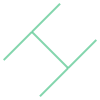

In [134]:
# given a segment, find the perpendiculars from each end
# thanks Georgy!
# https://stackoverflow.com/a/57072678
from shapely.ops import unary_union
def get_perps(street_seg):
    left_side = street_seg.parallel_offset(1.1, 'left')
    right_side = street_seg.parallel_offset(1.1, 'right')
    # keep them on the same side so you know that the two first coordinates are paired, etc.
    perp0 = LineString([left_side.boundary[1], right_side.boundary[0]])
    perp1 = LineString([left_side.boundary[0], right_side.boundary[1]])
    return perp0, perp1

def get_perp_points(street_seg):
    perp0, perp1 = get_perps(street_seg)
    left_points = (perp0.coords[0], perp1.coords[0])
    right_points = (perp0.coords[1], perp1.coords[1])
    return left_points, right_points

unary_union(list(get_perps(LineString([[0,1], [1,0]]))) + [LineString([[0,1], [1,0]])])
    
    

In [ ]:
# next steps:
# given the left and right sides: find the nearest nodes (within some distance?)
# find the shortest path between them (using only sidewalks? and also of capped distance?)
# delete all those nodes!